In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import efficientnet.keras as efn

base_model = efn.EfficientNetB4(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(11, activation='softmax'))

model.summary()

Using TensorFlow backend.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
flatten_1 (Flatten)          (None, 87808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                965899    
Total params: 18,639,715
Trainable params: 965,899
Non-trainable params: 17,673,816
_________________________________________________________________


In [3]:
import pandas as pd

df = pd.read_csv('input/google_data.csv')
df['file_name']=df['id']+'.jpg'
df=df[['file_name','dx','id']]
#df.head()

from sklearn.model_selection import train_test_split
label_dataframe=df.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(df, label_dataframe, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

(426, 2)
(1703, 2)
(237, 2)


In [4]:
train=pd.concat([X_train,y_train],axis=1)
train.head()
val=pd.concat([X_val,y_val],axis=1)
val.head()
test=pd.concat([X_test,y_test],axis=1)
test.head()

,file_name,id,dx
1078,moles (256).jpg.jpg,moles (256).jpg,moles
1668,virus (279).jpg.jpg,virus (279).jpg,virus
685,hyperpigmentation (94).jpg.jpg,hyperpigmentation (94).jpg,hyperpigmentation
1979,papule (85).jpg.jpg,papule (85).jpg,papule
976,moles (154).jpg.jpg,moles (154).jpg,moles


In [5]:
from sklearn import preprocessing
vle = preprocessing.LabelEncoder()
vle.fit(val['dx'])
label=vle.transform(val['dx']) 
print(list(vle.classes_))
val['label']=label
print(train.head())
le_name_mapping = dict(zip(vle.classes_, vle.transform(vle.classes_)))
print(le_name_mapping)

trle = preprocessing.LabelEncoder()
trle.fit(train['dx'])
label=trle.transform(train['dx']) 
print(list(trle.classes_))
train['label']=label
print(train.head())
le_name_mapping = dict(zip(trle.classes_, trle.transform(trle.classes_)))
print(le_name_mapping)

le = preprocessing.LabelEncoder()
le.fit(test['dx'])
label=le.transform(test['dx']) 
print(list(le.classes_))
test['label']=label
print(test.head())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

['acnea', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'moles', 'papule', 'pemphigus_vulgaris', 'scabies', 'virus']
                      file_name                     id           dx
1761   hypertrophy (75).jpg.jpg   hypertrophy (75).jpg  hypertrophy
1005        moles (183).jpg.jpg        moles (183).jpg        moles
1834  hypertrophy (148).jpg.jpg  hypertrophy (148).jpg  hypertrophy
1986        papule (92).jpg.jpg        papule (92).jpg       papule
2277   dermatitis (111).jpg.jpg   dermatitis (111).jpg   dermatitis
{'acnea': 0, 'bacterial_infection': 1, 'dermatitis': 2, 'fungal_infection': 3, 'hyperpigmentation': 4, 'hypertrophy': 5, 'moles': 6, 'papule': 7, 'pemphigus_vulgaris': 8, 'scabies': 9, 'virus': 10}
['acnea', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'moles', 'papule', 'pemphigus_vulgaris', 'scabies', 'virus']
                      file_name                     id           d

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
rescale = 1./255,
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.4, # Randomly zoom image 
shear_range=0.2,
width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=True)  # randomly flip images)


In [10]:
train_data= train_generator.flow_from_dataframe(
dataframe=train,
x_col="id",
y_col="dx",
batch_size=4,
seed=311,
directory="input/google_images",
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 1703 validated image filenames belonging to 11 classes.


In [11]:
test_generator=ImageDataGenerator(
rescale = 1./255)
test_data= test_generator.flow_from_dataframe(
dataframe=test,
x_col="id",
y_col="dx",
seed=45,
directory="input/google_images",
shuffle=False,
batch_size=1,
class_mode=None,
target_size=(224,224))

Found 237 validated image filenames.


In [12]:
val_data=test_generator.flow_from_dataframe(
dataframe=val,
directory="input/google_images",
x_col="id",
y_col="dx",
batch_size=1,
seed=45,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

Found 426 validated image filenames belonging to 11 classes.


In [13]:
from sklearn.utils import class_weight
import numpy as np

class_weight = np.round(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train['dx']))
print(class_weight)
print(train_data.class_indices)
print(val_data.class_indices)
print(train['dx'].value_counts())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.]
{'acnea': 0, 'bacterial_infection': 1, 'dermatitis': 2, 'fungal_infection': 3, 'hyperpigmentation': 4, 'hypertrophy': 5, 'moles': 6, 'papule': 7, 'pemphigus_vulgaris': 8, 'scabies': 9, 'virus': 10}
{'acnea': 0, 'bacterial_infection': 1, 'dermatitis': 2, 'fungal_infection': 3, 'hyperpigmentation': 4, 'hypertrophy': 5, 'moles': 6, 'papule': 7, 'pemphigus_vulgaris': 8, 'scabies': 9, 'virus': 10}
moles                  207
virus                  206
acnea                  186
papule                 186
hyperpigmentation      169
hypertrophy            154
dermatitis             150
bacterial_infection    130
pemphigus_vulgaris     118
fungal_infection       114
scabies                 83
Name: dx, dtype: int64


In [15]:
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.metrics import top_k_categorical_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                    patience=4, 
                                    verbose=1, 
                                    factor=0.2, 
                                    min_lr=0.0001)

In [18]:
model.compile(optimizer=SGD(lr=0.001, nesterov=True),loss="categorical_crossentropy",metrics=["accuracy", "top_k_categorical_accuracy"])
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=20,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

Epoch 1/20
425/425 [==============================] - 51s 119ms/step - loss: 3.7633 - accuracy: 0.2649 - top_k_categorical_accuracy: 0.7016 - val_loss: 8.4910 - val_accuracy: 0.2840 - val_top_k_categorical_accuracy: 0.7113
Epoch 2/20
425/425 [==============================] - 45s 106ms/step - loss: 3.7989 - accuracy: 0.2749 - top_k_categorical_accuracy: 0.7304 - val_loss: 8.6433 - val_accuracy: 0.2160 - val_top_k_categorical_accuracy: 0.6573
Epoch 3/20
425/425 [==============================] - 45s 106ms/step - loss: 3.8379 - accuracy: 0.2731 - top_k_categorical_accuracy: 0.7334 - val_loss: 1.5708 - val_accuracy: 0.2653 - val_top_k_categorical_accuracy: 0.6643
Epoch 4/20
425/425 [==============================] - 45s 106ms/step - loss: 4.0566 - accuracy: 0.2696 - top_k_categorical_accuracy: 0.7192 - val_loss: 7.3579 - val_accuracy: 0.2347 - val_top_k_categorical_accuracy: 0.6995
Epoch 5/20
425/425 [==============================] - 45s 105ms/step - loss: 4.1021 - accuracy: 0.2566 - top

In [19]:
base_model.trainable = True
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
flatten_1 (Flatten)          (None, 87808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                965899    
Total params: 1,091,099
Trainable params: 965,899
Non-trainable params: 125,200
_________________________________________________________________


In [21]:
model.compile(optimizer=SGD(lr=0.0001, nesterov=True),loss="categorical_crossentropy",metrics=["accuracy", "top_k_categorical_accuracy"])
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=5,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

Epoch 1/5
425/425 [==============================] - 185s 436ms/step - loss: 2.8430 - accuracy: 0.3172 - top_k_categorical_accuracy: 0.7734 - val_loss: 0.7543 - val_accuracy: 0.2700 - val_top_k_categorical_accuracy: 0.6972
Epoch 2/5
425/425 [==============================] - 161s 379ms/step - loss: 2.8165 - accuracy: 0.3261 - top_k_categorical_accuracy: 0.7728 - val_loss: 1.7134 - val_accuracy: 0.2629 - val_top_k_categorical_accuracy: 0.7066
Epoch 3/5
425/425 [==============================] - 161s 378ms/step - loss: 2.7755 - accuracy: 0.3455 - top_k_categorical_accuracy: 0.7734 - val_loss: 0.6988 - val_accuracy: 0.2887 - val_top_k_categorical_accuracy: 0.7347
Epoch 4/5
425/425 [==============================] - 160s 377ms/step - loss: 2.8237 - accuracy: 0.3149 - top_k_categorical_accuracy: 0.7728 - val_loss: 0.8834 - val_accuracy: 0.2700 - val_top_k_categorical_accuracy: 0.7254
Epoch 5/5
425/425 [==============================] - 160s 377ms/step - loss: 2.6504 - accuracy: 0.3437 - top

# **saving model**

## **Testing on single image**

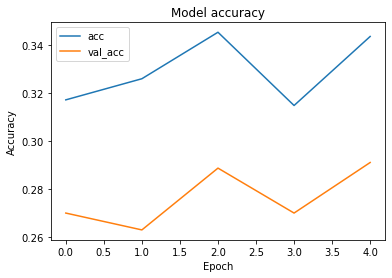

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

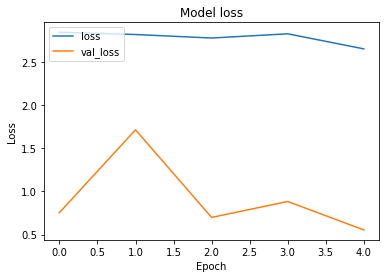

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [33]:
val_data.reset()
predictions = model.predict_generator(val_data, steps=val_data.samples/val_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)
print(y_pred)
ground_truth=val_data.classes

426/426 [==============================] - 15s 36ms/step
[ 2  6  6  1  0  4  0  6  0  5  8  4  3  1  7 10 10  5  8  6  5  1  7 10
  6  0  8  2  7  6  6  7  1  4  9  3  7  0  2 10  5  4  4  3 10  6  6  7
 10  0 10  1  0 10  6  1  7 10  5 10  5  8  6  2 10  6  6  0  1  1  0 10
  3  5  5  0 10  3 10 10  9  4  4  1  6  4 10  5  2  3  4  3  9  7  0  6
  6  4 10  0  0  0  2  2  3 10  8  0  8  1  4  3  8  2  6  4  4  1  5  9
  1  0  6 10  4  7 10  1  6  1  6  0  6  5  7  6  0  6  6  4  2  3  1  5
 10  7  3  1  6  3 10  2  4  6  5  2 10 10  5  1  3  4  3  8  4  9  9  0
  1 10 10  7  0  4  4  3 10  8  2  1  3  9  1  4  4  3  4 10  3 10  8  2
  4  4 10  6  5  6  9 10  3  6 10 10  1  1  9  8  1  3  8  3  4 10  0  1
  1 10 10  8  7 10 10  4  1 10  8  3  5  1  7  0 10  5  7 10  6  5  6  7
  6  4  3  4  9  7  6  3  8  5 10  1  8  2 10  2  5  8  3  1  9  9  7  4
  3  5  4  4 10 10  4  6  4  6  9  4 10  4  6 10  7  4  2  4 10  0  6 10
  6  7  7 10  5  0  1  8  3  6  0 10 10  4 10  8  1 10  4  6  5  6 

In [34]:
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['acnea', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'moles', 'papule', 'pemphigus_vulgaris', 'scabies', 'virus']
print(classification_report(val_data.classes, y_pred, target_names=target_names))

Classification Report
                     precision    recall  f1-score   support

              acnea       0.65      0.60      0.62        40
bacterial_infection       0.10      0.11      0.10        35
         dermatitis       0.32      0.19      0.24        36
   fungal_infection       0.14      0.17      0.15        29
  hyperpigmentation       0.25      0.43      0.32        35
        hypertrophy       0.21      0.20      0.21        30
              moles       0.49      0.51      0.50        55
             papule       0.21      0.13      0.16        53
 pemphigus_vulgaris       0.45      0.32      0.38        31
            scabies       0.09      0.11      0.10        18
              virus       0.24      0.25      0.24        64

           accuracy                           0.29       426
          macro avg       0.29      0.28      0.28       426
       weighted avg       0.30      0.29      0.29       426



In [38]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

237/237 [==============================] - 8s 35ms/step


In [39]:
print(y_pred)
ground_truth=test['label']
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['acnea', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'moles', 'papule', 'pemphigus_vulgaris', 'scabies', 'virus']
print(classification_report(ground_truth, y_pred, target_names=target_names))

[ 4  4  0  3  6  7  4 10  0  6 10  4  4  6  2  1  2  7  6  8  1 10  7 10
  4 10  5  6  4 10  5  7  4  3  2 10  2  6  2 10  3  7  1  7  8  5  0  8
  2 10  6  6 10  4  8  3 10  0  0  2  4  6  7  4  3  5  6  6  6  4  5  9
  0  4  6  0  3  5  5  4  4  5  7  4 10  4  4 10 10  0  9  2  4  0  0  4
  3 10  9  4  5  6  3  7  1  4  5  6  7  6  5  0  4  9  5  1  4  4  1  7
  4 10  6  1  4  9 10  4  8  4  3  4  1  6  6  4  8  0  4  4  4 10  7  0
  1  6  8  8  7  5 10 10  5  6  6  4  0  8  0 10  8  6  5  3  8  7 10  2
  6  7  9  2  5  0  4  8  9  0  0  7  2  2  8  2  0  1  4 10 10  0  9  7
  0  1  1  6  9  1  6  2  4  0  2  6  9 10  6  0  7  0  8  1  5  2 10  3
  1  8  2  6  8 10  2  8  3  4  5  5 10  5  0  0  7  8  4  0  3]
Classification Report
                     precision    recall  f1-score   support

              acnea       0.41      0.50      0.45        22
bacterial_infection       0.07      0.05      0.05        22
         dermatitis       0.11      0.15      0.13        13
   fungal_i

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

237/237 [==============================] - 8s 35ms/step


In [41]:
ground_truth=test['label']
print('Confusion Matrix')
print(confusion_matrix(ground_truth, y_pred))

Confusion Matrix
[[11  0  0  0  3  2  2  0  2  0  2]
 [ 0  1  2  1  2  2  3  4  1  2  4]
 [ 0  1  2  0  3  0  0  2  0  2  3]
 [ 2  0  3  2  1  1  3  0  0  2  0]
 [ 4  1  2  2  9  2  0  2  1  0  4]
 [ 1  1  2  3  4  8  0  2  3  0  0]
 [ 0  1  0  0  1  0 15  0  1  0  2]
 [ 4  4  3  2  7  4  3  3  0  0  3]
 [ 2  1  0  1  1  1  2  0  9  0  3]
 [ 2  1  2  1  5  0  0  1  1  2  0]
 [ 1  4  2  1  4  0  1  5  0  2  7]]


In [42]:
from keras.models import load_model

model.save('fine_google_data.h5')